In [3]:
import pandas as pd
from langchain_core.documents import Document as LangchainDocument
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores.utils import DistanceStrategy
from sentence_transformers import SentenceTransformer
from transformers import (
    Pipeline,
    AutoTokenizer,
    AutoModelForCausalLM,
    AutoModelForQuestionAnswering,
    BitsAndBytesConfig,
    DefaultDataCollator,
    TrainingArguments,
    Trainer,
)

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from typing import List, Optional
import pickle
import time

In [4]:
test_data= pd.read_json("../qa/wikipedia-dev.json")

In [5]:
print(f"Test set size: {len(test_data)}")

Test set size: 7993


In [6]:
#Build a list of docs from the downloaded Wikipedia documents
def getDocs(examples):
    # List of docs
    docs = []
    # Extracting metadata and filenames from the examples (training data)
    for example in examples["Data"]:
        filename = example["EntityPages"][0]["Filename"]
        with open(f"..//evidence/wikipedia/{filename}", "r") as file:
            context_text = file.read()
        # Create a Document for RAG
        newDoc = LangchainDocument(
                metadata={
                    'question_id': example['QuestionId'],
                    'source': example['EntityPages'][0]['DocSource'],
                    'answer_type': example['Answer']['Type'],
                    'entity_name': example['Answer'].get('NormalizedValue', ''), # Default to empty string if missing
                    'aliases': example['Answer'].get('Aliases', []), # Default to empty list if missing
                    'normalized_value': example['Answer'].get('NormalizedValue', ''), # Default to empty string if missing
                    'filename': example['EntityPages'][0]['Filename'],
                },
                page_content=context_text
        )
        docs.append(newDoc)
    return docs

In [7]:
RAW_KNOWLEDGE_BASE = getDocs(test_data)

In [8]:
# Function to split the documents into chunks with TQDM progress bars
EMBEDDING_MODEL_NAME = "thenlper/gte-small"
def split_documents(
    chunk_size: int,
    knowledge_base: List[LangchainDocument],
    tokenizer_name: Optional[str] = EMBEDDING_MODEL_NAME,
) -> List[LangchainDocument]:
    """
    Split documents into chunks of maximum size `chunk_size` tokens and return a list of documents.
    Shows progress using TQDM.
    """
    print("Loading tokenizer...")
    start_time = time.time()
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
    print(f"Tokenizer loaded in {time.time() - start_time:.2f} seconds")
    
    TRIVIAQA_SEPARATORS = [
        "\n\n",  # Paragraph breaks
        "\n",    # Line breaks
        ". ",    # Sentences
        "? ",    # Questions
        "! ",    # Exclamations
        "; ",    # Semicolons
        ": ",    # Colons
        ", ",    # Commas
        " ",     # Words
        ""       # Characters
    ]
    
    print("Creating text splitter...")
    start_time = time.time()
    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        tokenizer,
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size / 10),
        add_start_index=True,
        strip_whitespace=True,
        separators=TRIVIAQA_SEPARATORS,
    )
    print(f"Text splitter created in {time.time() - start_time:.2f} seconds")
    
    docs_processed = []
    print(f"Processing {len(knowledge_base)} documents...")
    
    # Using tqdm to show progress
    for doc in tqdm(knowledge_base, desc="Splitting documents"):
        chunks = text_splitter.split_documents([doc])
        docs_processed.extend(chunks)
    
    print(f"Created {len(docs_processed)} chunks from {len(knowledge_base)} documents")
    
    # Remove duplicates with progress bar
    print("Removing duplicates...")
    start_time = time.time()
    unique_texts = {}
    docs_processed_unique = []
    
    for doc in tqdm(docs_processed, desc="Removing duplicates"):
        if doc.page_content not in unique_texts:
            unique_texts[doc.page_content] = True
            docs_processed_unique.append(doc)
    
    print(f"Removed {len(docs_processed) - len(docs_processed_unique)} duplicate chunks in {time.time() - start_time:.2f} seconds")
    print(f"Final document count: {len(docs_processed_unique)} chunks")
    
    return docs_processed_unique

# Processing the RAW_KNOWLEDGE_BASE (validation_data)
print("Starting document processing...")
overall_start_time = time.time()

docs_processed = split_documents(
    512,  # We choose a chunk size adapted to our model
    RAW_KNOWLEDGE_BASE,
    tokenizer_name=EMBEDDING_MODEL_NAME,
)



Starting document processing...
Loading tokenizer...
Tokenizer loaded in 0.14 seconds
Creating text splitter...
Text splitter created in 0.00 seconds
Processing 7993 documents...


Splitting documents:   0%|          | 0/7993 [00:00<?, ?it/s]

Created 124666 chunks from 7993 documents
Removing duplicates...


Removing duplicates:   0%|          | 0/124666 [00:00<?, ?it/s]

Removed 44304 duplicate chunks in 0.17 seconds
Final document count: 80362 chunks


  0%|          | 0/80362 [00:00<?, ?it/s]

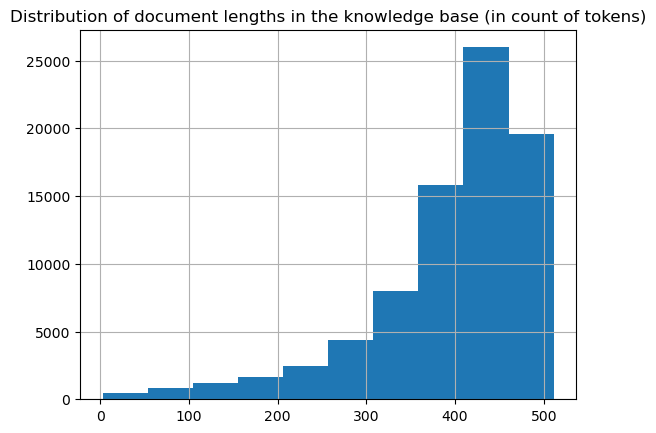

In [9]:
with open("test_data_saved/test_docs_processed.pkl", "wb") as file:
    pickle.dump(docs_processed, file)
tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME)
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

In [10]:
EMBEDDING_MODEL_NAME = "thenlper/gte-small"
embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True},  # Set `True` for cosine similarity
)

In [11]:
KNOWLEDGE_VECTOR_DATABASE = FAISS.from_documents(docs_processed, embedding_model, distance_strategy=DistanceStrategy.COSINE)

In [12]:
faiss_index_path = "test_data_saved/Faiss"
KNOWLEDGE_VECTOR_DATABASE.save_local(faiss_index_path)

In [15]:
user_query = "Who was the American President when the Berlin Wall was constructed?"

print(f"\nStarting retrieval for {user_query=}...")
retrieved_docs = KNOWLEDGE_VECTOR_DATABASE.similarity_search(query=user_query, k=5)

for i in range(3):
    print(f"\n==================================Top {i+1} document==================================")
    print(retrieved_docs[i].page_content)
    print("==================================Metadata==================================")
    print(retrieved_docs[i].metadata)



Starting retrieval for user_query='Who was the American President when the Berlin Wall was constructed?'...

==================================Top 1 document==================================
On June 26, President Kennedy gave a public speech in West Berlin reiterating the American commitment to Germany and criticizing communism. He was met with an ecstatic response from a massive audience.

Kennedy used the construction of the Berlin Wall as an example of the failures of communism: "Freedom has many difficulties, and democracy is not perfect. But we have never had to put a wall up to keep our people in, to prevent them from leaving us." The speech is known for its famous phrase "Ich bin ein Berliner" ("I am a citizen of Berlin"). A million people were on the street for the speech. He remarked to Ted Sorensen afterwards: "We'll never have another day like this one, as long as we live."

Israel

In 1960, Kennedy stated: "Israel will endure and flourish. It is the child of hope and the 